In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
grayImage = r'albert-einstein_gray.jpg'
I_gray = cv2.imread(grayImage,cv2.IMREAD_GRAYSCALE)

In [3]:
print(I_gray.shape)

(949, 728)


## Affine Transformation

In [4]:
def getExtentsAffine(T,rMax,cMax):
    Cords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
    A_dash = T.dot(Cords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR-minR+1, maxC-minC+1
    return minR,minC,maxR,maxC,H,W

In [5]:
def BilinearInterpolate(r,c,I):
    lc = int(c)
    rc = lc+1
    wr = c - lc
    wl = rc - c
    tr = int(r)
    br = tr+1
    wt = br-r
    wb = r-tr
    if tr >= 0 and br < I.shape[0] and lc >=0 and rc < I.shape[1]:
        a = wl*I[tr,lc] + wr*I[tr,rc]
        b = wl*I[br,lc] + wr*I[br,rc]
        g = wt*a + wb*b
        return np.uint8(g)
    else:
        return 0

In [6]:
def TransformAffine(T,I_gray):
    rMax,cMax = I_gray.shape[0],I_gray.shape[1]
    minR,minC,maxR,maxC,H,W = getExtentsAffine(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype='uint8')
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            P_dash = np.array([new_i,new_j,1])
            P = Tinv.dot(P_dash)
            i , j = P[0] , P[1]
            if i < 0 or i >= I_gray.shape[0] or j < 0 or j >= I_gray.shape[1]:
                pass
            else:
                g = BilinearInterpolate(i,j,I_gray)
                I2[new_i-minR,new_j-minC] = g
    return I2

Apply

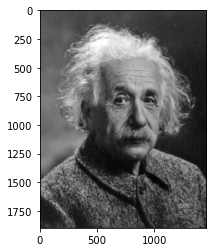

In [7]:
T = np.array([[2,0,0],
              [0,2,0],
              [0,0,1]])
I2 = TransformAffine(T,I_gray)
plt.imshow(I2,cmap='gray')

In [8]:
print(I2.shape)

(1897, 1455)


## Exercise

xoay ảnh 45 độ ngược chiều đồng hồ và dịch chuyển tại điểm bất kỳ.

In [9]:
alpha = 45
cosa = np.cos(np.deg2rad(alpha))
sina = np.sin(np.deg2rad(alpha))
R = np.array([[cosa,-sina,0],
              [sina,cosa,0],
              [0,0,1]])

In [10]:
D = np.array([[1,0,-200],
              [0,1,-300],
              [0,0,1]]) # tại điểm (-200, -300) làm tâm xoay ảnh

In [11]:
mat = np.linalg.inv(D).dot(R).dot(D) # mat = D^-1*R*D

In [12]:
mat

array([[  0.70710678,  -0.70710678, 270.71067812],
       [  0.70710678,   0.70710678, -53.55339059],
       [  0.        ,   0.        ,   1.        ]])

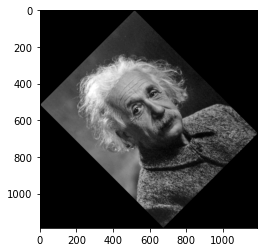

In [13]:
img = TransformAffine(mat,I_gray)
plt.imshow(img,cmap='gray')

## Reflect through a line

Đối xứng ảnh qua đồ thị hàm số y = x + 2

In [14]:
a = -45
cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))
Rotation = np.array([[cosa,-sina,0], [sina,cosa,0], [0,0,1]])

In [15]:
T = np.array([[1,0,-2], [0,1,0], [0,0,1]])
Reflection = np.array([[1,0,0], [0,-1, 0], [0, 0, 1]])

In [16]:
result = np.linalg.inv(T).dot(np.linalg.inv(Rotation)).dot(Reflection).dot(Rotation).dot(T)
result

array([[ 0.,  1.,  2.],
       [ 1.,  0., -2.],
       [ 0.,  0.,  1.]])

In [17]:
image = TransformAffine(result,I_gray)

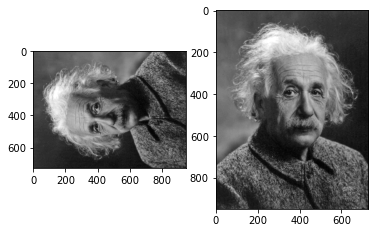

In [18]:
plt.subplot(121)
plt.imshow(image, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_gray, cmap = 'gray')

## Projective Transformation

In [19]:
def getExtentsProjective(T,rMax,cMax):
    Cords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
    A_dash = T.dot(Cords.T)
    A_dash = A_dash/A_dash[2,:] # convert homogenous coordinate to non-homogenous
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR-minR+1, maxC-minC+1
    return minR,minC,maxR,maxC,H,W

In [20]:
def TransformProjective(T,I_gray):
    rMax,cMax = I_gray.shape[0],I_gray.shape[1]
    minR,minC,maxR,maxC,H,W = getExtentsProjective(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype='uint8')
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            P_dash = np.array([new_i,new_j,1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            i , j = P[0] , P[1]
            if i < 0 or i >= I_gray.shape[0] or j < 0 or j >= I_gray.shape[1]:
                pass
            else:
                g = BilinearInterpolate(i,j,I_gray)
                I2[new_i-minR,new_j-minC] = g
    return I2

Apply

In [21]:
a = 30
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]])
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)
H = A
H[2,:] = np.array([0.001,0.0001,1])

In [22]:
print(H)

[[ 1.12583302e+00 -8.70834875e-02 -2.91651246e+00]
 [ 3.50000000e-01  7.81217783e-01 -1.74871131e+01]
 [ 1.00000000e-03  1.00000000e-04  1.00000000e+00]]


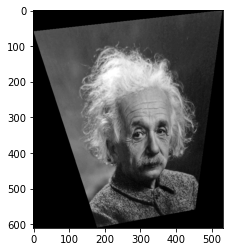

In [23]:
I2 = TransformProjective(H,I_gray)
plt.imshow(I2,cmap='gray')